In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Reading data**

In [60]:
df = pd.read_excel('/content/E Commerce Dataset.xlsx')
print(df.head())

   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  Number

### **Data Cleaning**

In [61]:
print(df.isnull().sum())

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [62]:
# Handling missing values (Filling missing values with median for numerical columns)
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column].fillna(df[column].median(), inplace=True)

In [63]:
print(df.isnull().sum())

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64


In [64]:
# Replacing values for clarity
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace('Phone', 'Mobile Phone')
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace(['CC', 'COD'], ['Credit Card', 'Cash on Delivery'])

In [65]:
print(df['PreferredLoginDevice'].unique())
print(df['PreferedOrderCat'].unique())
print(df['PreferredPaymentMode'].unique())

['Mobile Phone' 'Computer']
['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']


In [68]:
# Dropping unnecessary columns
df.drop(['CustomerID', 'CityTier', 'PreferredLoginDevice', 'NumberOfDeviceRegistered', 'MaritalStatus'], axis=1, inplace=True)

In [69]:
print(df.columns)

Index(['Churn', 'Tenure', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender',
       'HourSpendOnApp', 'PreferedOrderCat', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')


### **Encoding categorical columns**

In [71]:
# One-Hot Encoding for columns with more than two categories
one_hot_columns = ['PreferredPaymentMode', 'PreferedOrderCat']
df = pd.get_dummies(df, columns=one_hot_columns)

In [72]:
# Label Encoding for columns with two categories
label_enc = LabelEncoder()
two_value_columns = ['Gender']

for col in two_value_columns:
    df[col] = label_enc.fit_transform(df[col])

In [73]:
print(df.head())

   Churn  Tenure  WarehouseToHome  Gender  HourSpendOnApp  SatisfactionScore  \
0      1     4.0              6.0       0             3.0                  2   
1      1     9.0              8.0       1             3.0                  3   
2      1     9.0             30.0       1             2.0                  3   
3      1     0.0             15.0       1             2.0                  5   
4      1     0.0             12.0       1             3.0                  5   

   NumberOfAddress  Complain  OrderAmountHikeFromlastYear  CouponUsed  ...  \
0                9         1                         11.0         1.0  ...   
1                7         1                         15.0         0.0  ...   
2                6         1                         14.0         0.0  ...   
3                8         0                         23.0         0.0  ...   
4                3         0                         11.0         1.0  ...   

   PreferredPaymentMode_Cash on Delivery  Preferre

### **Pre-processing**

In [74]:
print(df.describe())

             Churn       Tenure  WarehouseToHome       Gender  HourSpendOnApp  \
count  5630.000000  5630.000000      5630.000000  5630.000000     5630.000000   
mean      0.168384    10.134103        15.566785     0.601066        2.934636   
std       0.374240     8.357951         8.345961     0.489723        0.705528   
min       0.000000     0.000000         5.000000     0.000000        0.000000   
25%       0.000000     3.000000         9.000000     0.000000        2.000000   
50%       0.000000     9.000000        14.000000     1.000000        3.000000   
75%       0.000000    15.000000        20.000000     1.000000        3.000000   
max       1.000000    61.000000       127.000000     1.000000        5.000000   

       SatisfactionScore  NumberOfAddress     Complain  \
count        5630.000000      5630.000000  5630.000000   
mean            3.066785         4.214032     0.284902   
std             1.380194         2.583586     0.451408   
min             1.000000         1.000

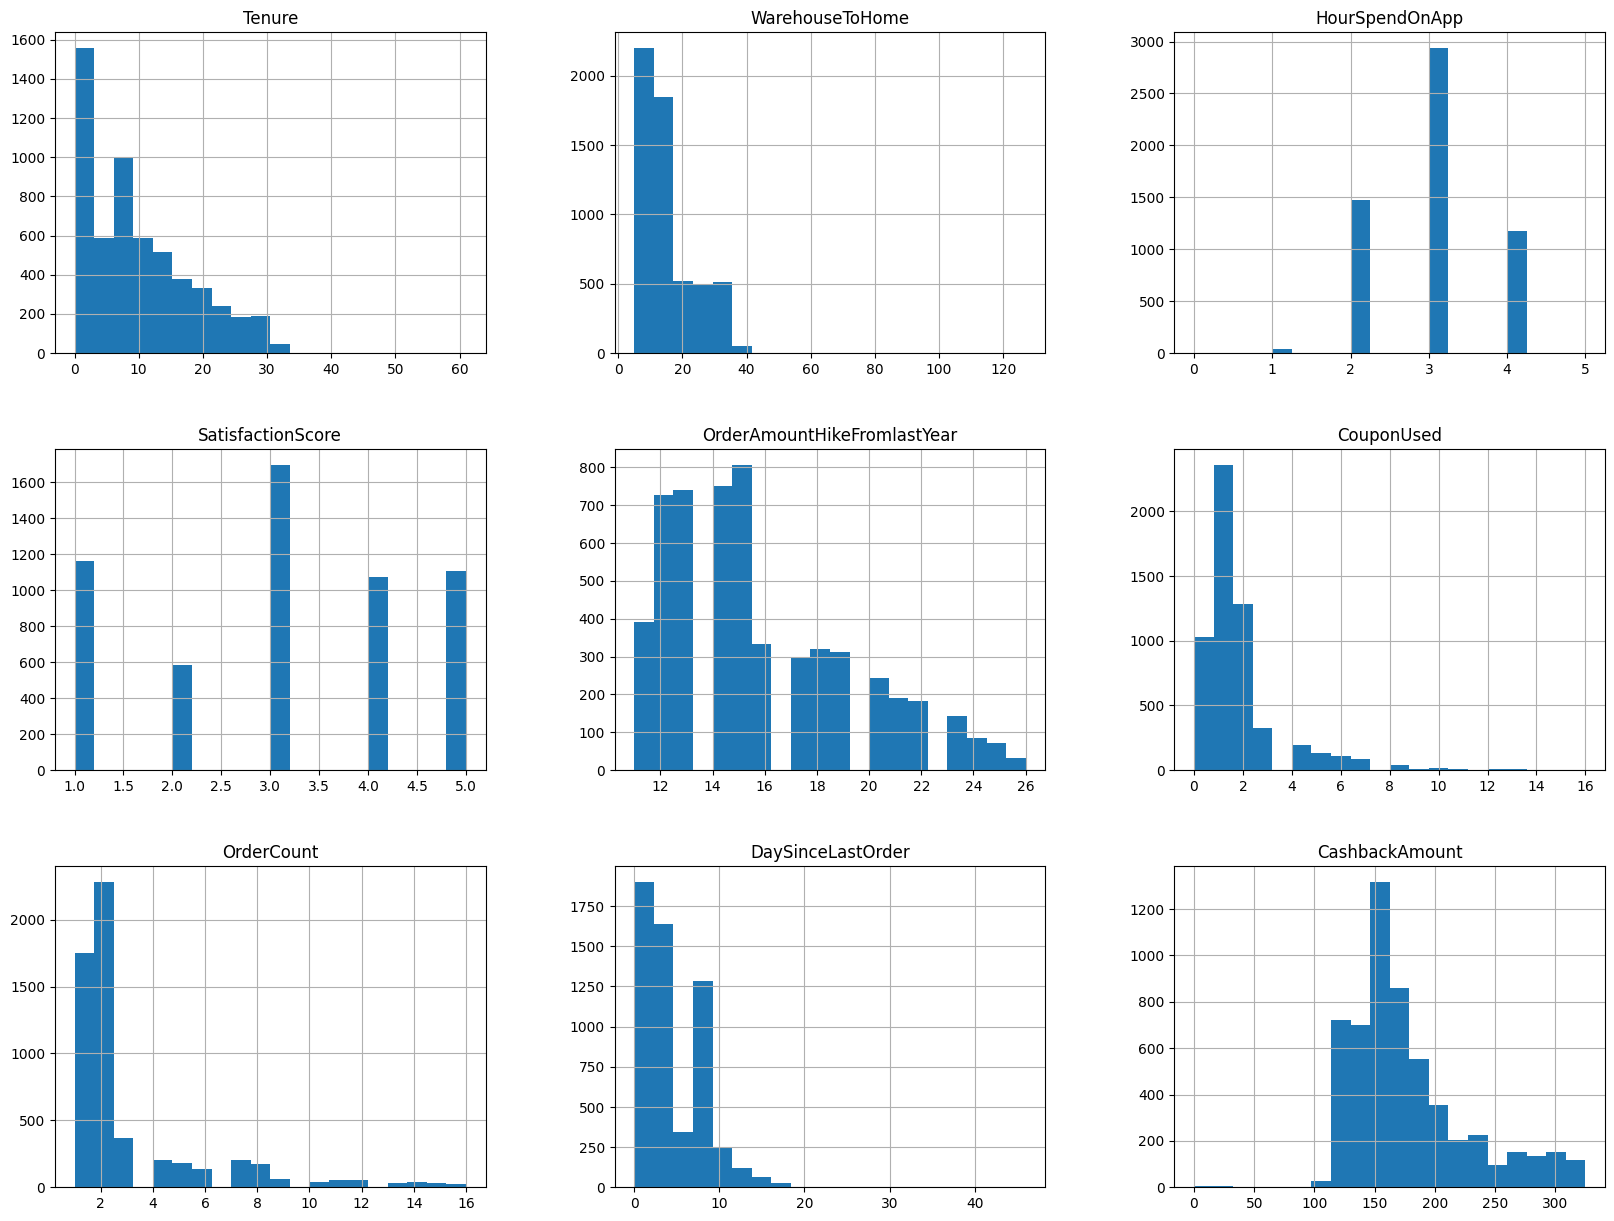

In [75]:
# Distribution of numerical variables
columns_of_interest = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'SatisfactionScore', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

df[columns_of_interest].hist(bins=20, figsize=(20, 15))
plt.show()

### **Correlation Analysis**

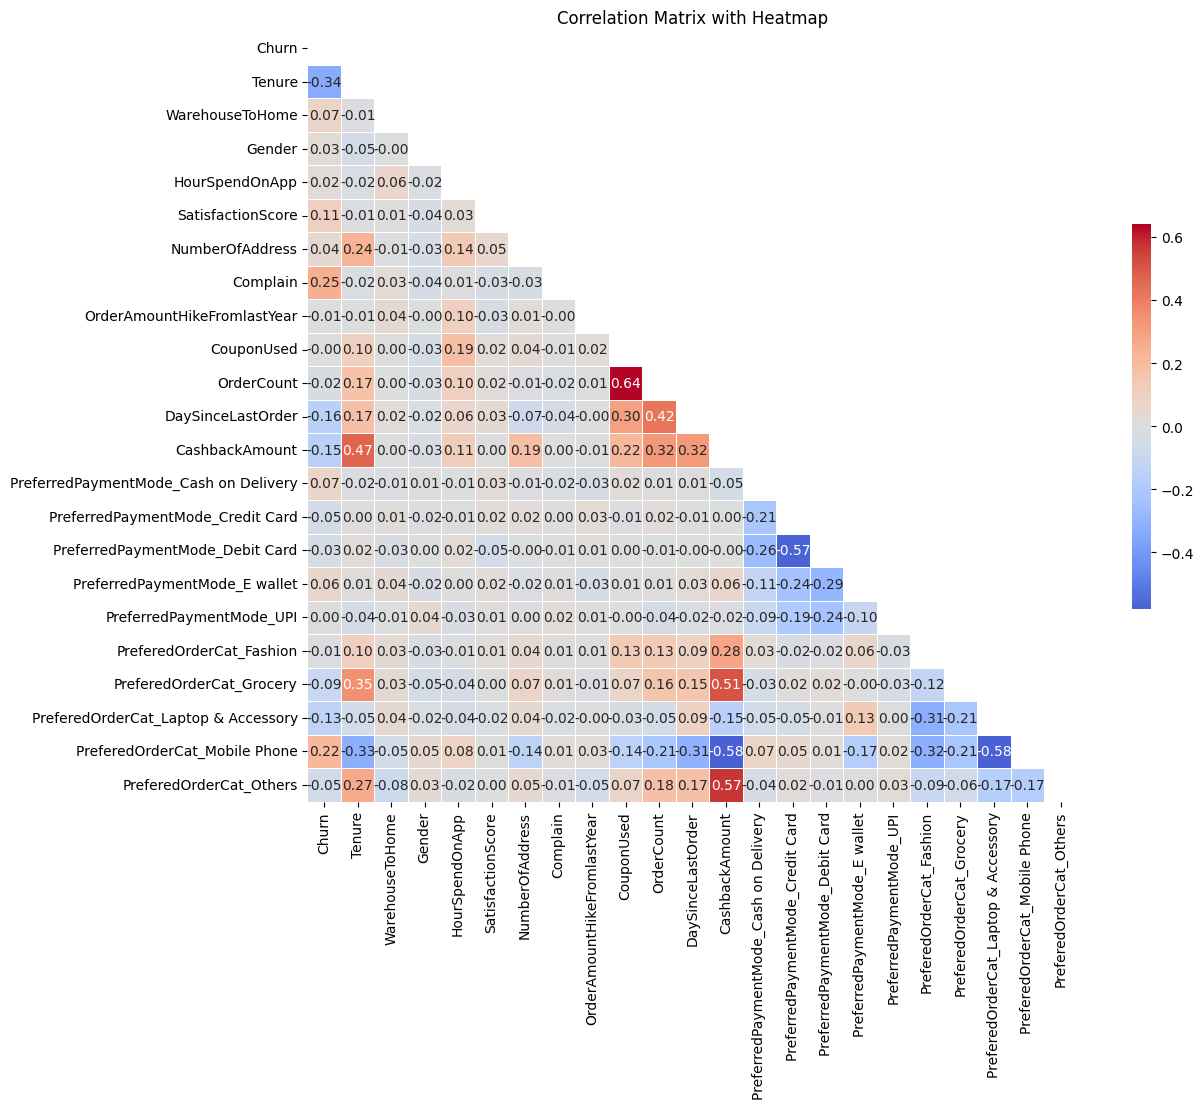

In [76]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))

# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix with Heatmap')
plt.show()

### **Feature Engineering**

Engagement Score: weighted sum of features to capture overall customer engagement

In [77]:
# Assign weights based on perceived importance
weight_hours_on_app = 0.5  # Assuming time on app is most indicative of engagement
weight_order_count = 0.3   # Next most important
weight_coupons_used = 0.2  # Least important

# Calculate the weighted engagement score
df['EngagementScore'] = (df['HourSpendOnApp'] * weight_hours_on_app) + \
                        (df['OrderCount'] * weight_order_count) + \
                        (df['CouponUsed'] * weight_coupons_used)

Normalized Cashback: Considering 'CashbackAmount' in relation to 'OrderAmountHikeFromlastYear' could give insights into the effectiveness of incentives. For example, a high cashback amount with a low order hike might be more indicative of customer retention.

In [78]:
df['NormalizedCashback'] = df['CashbackAmount'] / df['OrderAmountHikeFromlastYear']

Recent Engagement: A feature that combines 'DaySinceLastOrder' with 'HourSpendOnApp' might indicate recent engagement, which could be predictive of churn.

In [79]:
df['RecentEngagement'] = (df['DaySinceLastOrder'] < 30) * df['HourSpendOnApp']

checking new columns for correlation

In [80]:
new_features = ['EngagementScore', 'NormalizedCashback', 'RecentEngagement']

# Calculating the correlation matrix
new_features_with_churn = new_features + ['Churn']
corr_matrix_new_features = df[new_features_with_churn].corr()

# Extracting the correlations of the new features
churn_correlations_new_features = corr_matrix_new_features['Churn'].sort_values(ascending=False)

print(churn_correlations_new_features)

Churn                 1.000000
RecentEngagement      0.018185
EngagementScore      -0.011844
NormalizedCashback   -0.110921
Name: Churn, dtype: float64


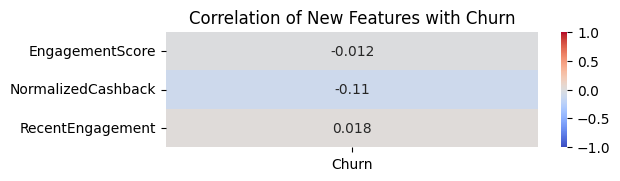

In [81]:
# Heatmap of correlations with churn for the new features
plt.figure(figsize=(6, len(new_features) * 0.5))
sns.heatmap(corr_matrix_new_features.loc[new_features, ['Churn']],
            vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation of New Features with Churn')
plt.show()

### **Feature Importance - Random Forest**

In [82]:
df.columns

Index(['Churn', 'Tenure', 'WarehouseToHome', 'Gender', 'HourSpendOnApp',
       'SatisfactionScore', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Fashion', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'EngagementScore', 'NormalizedCashback',
       'RecentEngagement'],
      dtype='object')

In [83]:
# Preparing the features and target variable
X = df.drop('Churn', axis=1)
y = df['Churn']

In [84]:
# Initializing and fitting the RandomForestClassifier
forest = RandomForestClassifier(random_state=42)
forest.fit(X, y)

RandomForestClassifier(random_state=42)

In [85]:
# Getting the feature importances
importances = forest.feature_importances_

# Transforming the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sorting the DataFrame to find the most important features
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

print(feature_importances)

                                  feature  importance
0                                  Tenure    0.218915
1                          CashbackAmount    0.096834
2                      NormalizedCashback    0.088631
3                         WarehouseToHome    0.074889
4                         NumberOfAddress    0.065134
5                       DaySinceLastOrder    0.063880
6                                Complain    0.062883
7             OrderAmountHikeFromlastYear    0.053573
8                       SatisfactionScore    0.045011
9                         EngagementScore    0.039337
10                             OrderCount    0.025961
11          PreferedOrderCat_Mobile Phone    0.021221
12                             CouponUsed    0.021170
13                                 Gender    0.016446
14          PreferredPaymentMode_E wallet    0.015194
15       PreferredPaymentMode_Credit Card    0.013017
16        PreferredPaymentMode_Debit Card    0.012482
17                       Rec

### **Selecting our features**






In [86]:
threshold = 0.03

# Selecting features with importance above the threshold we set above
selected_features = feature_importances[feature_importances['importance'] > threshold]['feature']

print("Selected features:", selected_features.tolist())

# Updated DataFrame that only includes the selected features plus the target variable
df_selected = df[selected_features.tolist() + ['Churn']]

print(df_selected.head())

Selected features: ['Tenure', 'CashbackAmount', 'NormalizedCashback', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'Complain', 'OrderAmountHikeFromlastYear', 'SatisfactionScore', 'EngagementScore']
   Tenure  CashbackAmount  NormalizedCashback  WarehouseToHome  \
0     4.0          159.93           14.539091              6.0   
1     9.0          120.90            8.060000              8.0   
2     9.0          120.28            8.591429             30.0   
3     0.0          134.07            5.829130             15.0   
4     0.0          129.60           11.781818             12.0   

   NumberOfAddress  DaySinceLastOrder  Complain  OrderAmountHikeFromlastYear  \
0                9                5.0         1                         11.0   
1                7                0.0         1                         15.0   
2                6                3.0         1                         14.0   
3                8                3.0         0                        

### **Splitting the data**

In [87]:
X = df_selected.drop('Churn', axis=1)
y = df_selected['Churn']

# Train and test datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Testing dataset into test and validation datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4504
Validation set size: 563
Test set size: 563


### **Checking the distribution of our target value**

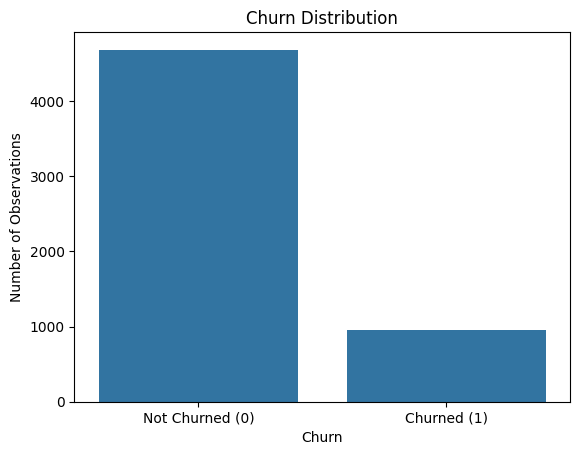

In [88]:
# Use seaborn's countplot to show the distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Number of Observations')
plt.xticks(ticks=[0, 1], labels=['Not Churned (0)', 'Churned (1)'])  # Adjust labels for clarity
plt.show()

### **SMOTE (Synthetic Minority Over-sampling Technique)**

In [89]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### **Training Decision Tree and Random Forest**

In [91]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [92]:
# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **Scale Features and Train Logistic Regression and Neural Networks**

In [94]:
scaler = StandardScaler()

In [95]:
# Fit on training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [96]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [97]:
# Neural Network (Multi-layer Perceptron classifier)
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

### **Generating Predictions**

In [98]:
# Decision Tree and Random Forest predictions
y_val_pred_dt = dt_classifier.predict(X_val)
y_val_pred_rf = rf_classifier.predict(X_val)

In [99]:
# Logistic Regression and MLP Classifier predictions (using scaled features)
y_val_pred_logreg = log_reg.predict(X_val_scaled)
y_val_pred_mlp = mlp_classifier.predict(X_val_scaled)

### **Evaluate Each Model**

In [100]:
# Defining a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='binary'),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'F1 Score': f1_score(y_true, y_pred, average='binary'),
        'ROC AUC Score': roc_auc_score(y_true, y_pred)
    }
    return metrics

# Calculating metrics for each model
dt_metrics = calculate_metrics(y_val, y_val_pred_dt)
rf_metrics = calculate_metrics(y_val, y_val_pred_rf)
logreg_metrics = calculate_metrics(y_val, y_val_pred_logreg)
mlp_metrics = calculate_metrics(y_val, y_val_pred_mlp)

print("Decision Tree Metrics:", dt_metrics)
print("Random Forest Metrics:", rf_metrics)
print("Logistic Regression Metrics:", logreg_metrics)
print("MLP Classifier Metrics:", mlp_metrics)


Decision Tree Metrics: {'Accuracy': 0.9520426287744227, 'Precision': 0.8658536585365854, 'Recall': 0.8160919540229885, 'F1 Score': 0.8402366863905325, 'ROC AUC Score': 0.8964913551627547}
Random Forest Metrics: {'Accuracy': 0.9715808170515098, 'Precision': 0.961038961038961, 'Recall': 0.8505747126436781, 'F1 Score': 0.9024390243902438, 'ROC AUC Score': 0.9221360958176374}
Logistic Regression Metrics: {'Accuracy': 0.8809946714031972, 'Precision': 0.7083333333333334, 'Recall': 0.39080459770114945, 'F1 Score': 0.5037037037037037, 'ROC AUC Score': 0.6806964164976336}
MLP Classifier Metrics: {'Accuracy': 0.9218472468916519, 'Precision': 0.864406779661017, 'Recall': 0.5862068965517241, 'F1 Score': 0.6986301369863013, 'ROC AUC Score': 0.7847000869313242}


### **Comparing each model's predictions**

In [101]:
import pandas as pd

# Creating a DataFrame from actual values
results_comparison = pd.DataFrame(y_val)
results_comparison.reset_index(drop=True, inplace=True)

# Adding predictions from each model
results_comparison['DT Predictions'] = y_val_pred_dt
results_comparison['RF Predictions'] = y_val_pred_rf
results_comparison['LogReg Predictions'] = y_val_pred_logreg
results_comparison['MLP Predictions'] = y_val_pred_mlp

print(results_comparison.head())

   Churn  DT Predictions  RF Predictions  LogReg Predictions  MLP Predictions
0      0               0               0                   0                0
1      0               0               0                   0                0
2      1               0               0                   1                1
3      0               0               0                   0                0
4      0               0               0                   0                0


### **Comparing "feature importance" for Decision Tree and Random Forest**

Decision Tree

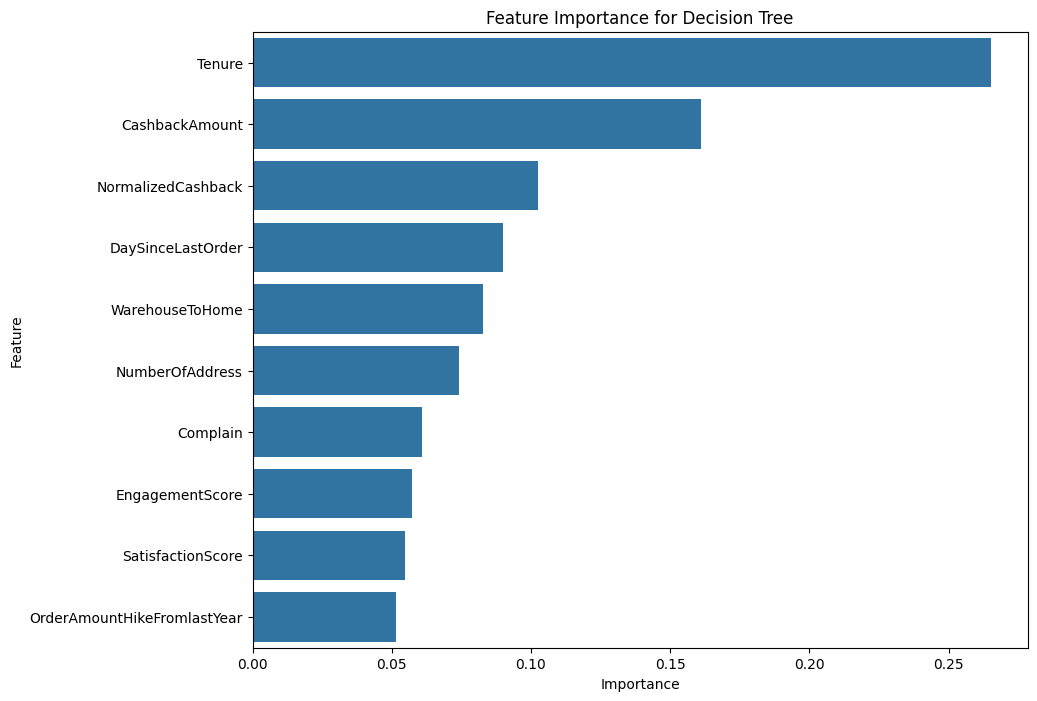

In [102]:
dt_feature_importances = dt_classifier.feature_importances_
dt_features = X_train.columns
dt_importances_df = pd.DataFrame({'Feature': dt_features, 'Importance': dt_feature_importances})
dt_importances_df = dt_importances_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importances_df)
plt.title('Feature Importance for Decision Tree')
plt.show()

Random Forest

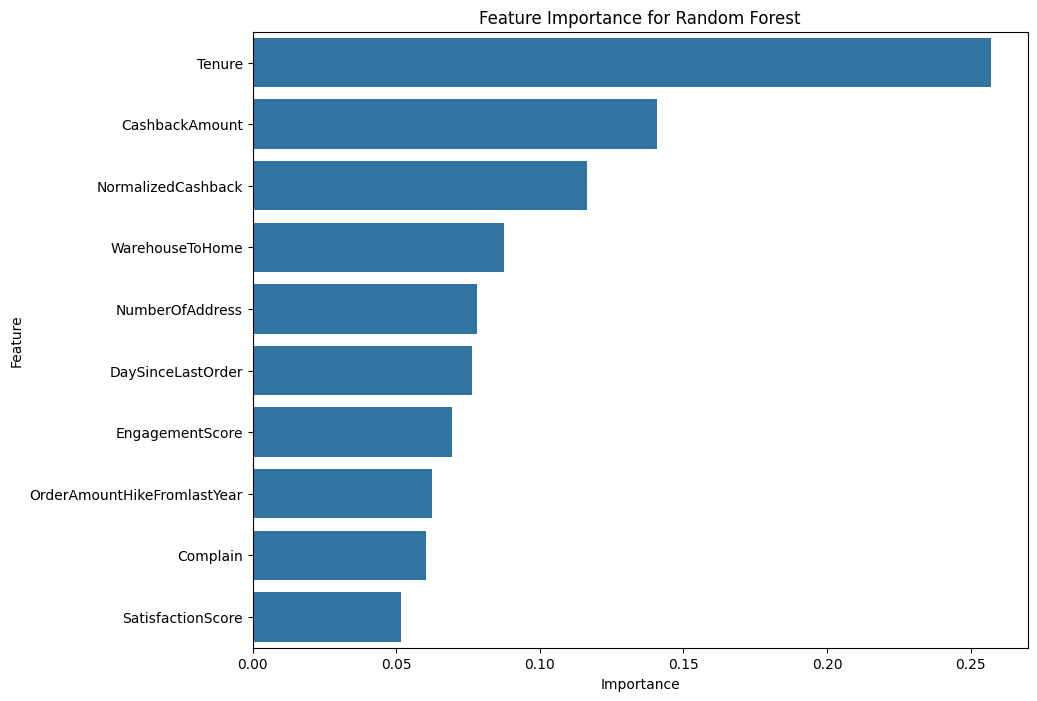

In [103]:
rf_feature_importances = rf_classifier.feature_importances_
rf_features = X_train.columns
rf_importances_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importances})
rf_importances_df = rf_importances_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importances_df)
plt.title('Feature Importance for Random Forest')
plt.show()

In [104]:
# Calculate the average churn probability from all models
average_prob = (y_val_pred_dt + y_val_pred_rf + y_val_pred_logreg + y_val_pred_mlp) / 4

# Create a DataFrame for the average probabilities
probabilities_df = pd.DataFrame({'Churn_Probability': average_prob})

# Define risk segments based on churn probability thresholds
def assign_risk_segment(probability):
    if probability < 0.3:
        return 'Low Risk'
    elif probability < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Assign risk segments
probabilities_df['Segment'] = probabilities_df['Churn_Probability'].apply(assign_risk_segment)

# Calculate summary statistics for each segment
segment_summary = probabilities_df.groupby('Segment')['Churn_Probability'].agg(['mean', 'min', 'max', 'count'])

# Reset the index for better readability
segment_summary.reset_index(inplace=True)

# Print the segment summary
print(segment_summary)

       Segment      mean   min   max  count
0    High Risk  0.890000  0.75  1.00     50
1     Low Risk  0.011458  0.00  0.25    480
2  Medium Risk  0.500000  0.50  0.50     33


### **Confusion Matrix**

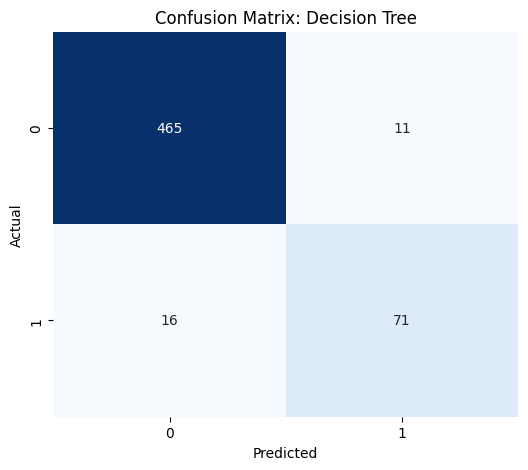

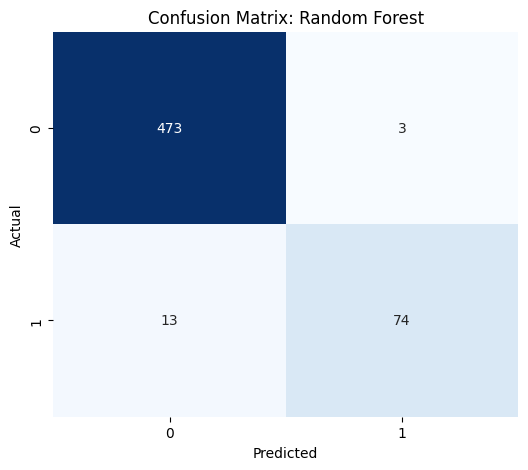

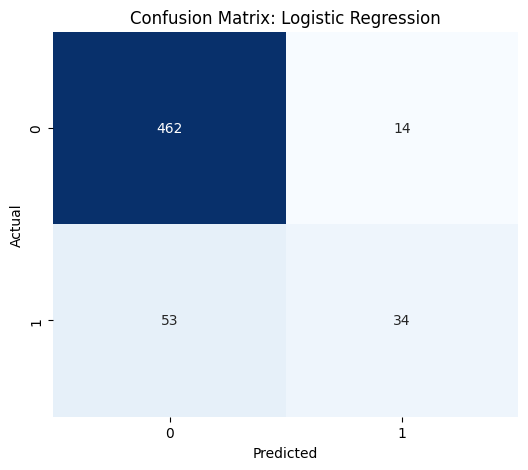

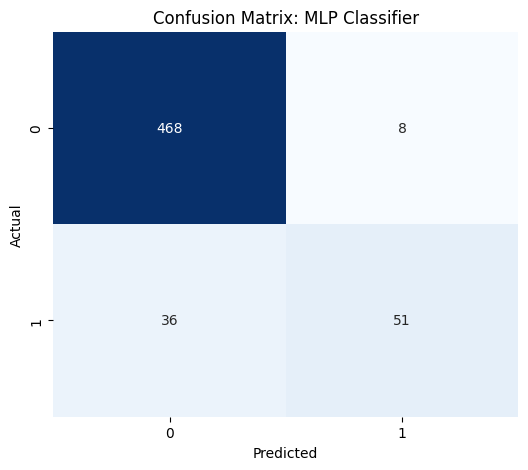

In [105]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plotting confusion matrix for each model
plot_confusion_matrix(y_val, y_val_pred_dt, "Decision Tree")
plot_confusion_matrix(y_val, y_val_pred_rf, "Random Forest")
plot_confusion_matrix(y_val, y_val_pred_logreg, "Logistic Regression")
plot_confusion_matrix(y_val, y_val_pred_mlp, "MLP Classifier")